## A/B testing analysis 🕸

---



### Data collection

---



In [ ]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from statsmodels.stats.proportion import proportions_ztest

In [ ]:
from google.colab import drive
import os

drive.mount("/content/drive")
os.chdir("/content/drive/MyDrive")

Mounted at /content/drive


In [ ]:
df = pd.read_csv('ab_testing.csv', parse_dates=['date'])

### Data overview and preparation

---



In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 800996 entries, 0 to 800995
Data columns (total 9 columns):
 #   Column      Non-Null Count   Dtype         
---  ------      --------------   -----         
 0   date        800996 non-null  datetime64[ns]
 1   country     800996 non-null  object        
 2   device      800996 non-null  object        
 3   continent   800996 non-null  object        
 4   channel     800996 non-null  object        
 5   test        800996 non-null  int64         
 6   test_group  800996 non-null  int64         
 7   event_name  800996 non-null  object        
 8   value       800996 non-null  int64         
dtypes: datetime64[ns](1), int64(3), object(5)
memory usage: 55.0+ MB


In [ ]:
df.head()

,date,country,device,continent,channel,test,test_group,event_name,value
0,2020-11-01,Lithuania,mobile,Europe,Organic Search,2,2,new account,1
1,2020-11-01,Lithuania,mobile,Europe,Organic Search,1,2,new account,1
2,2020-11-01,El Salvador,desktop,Americas,Social Search,2,1,new account,1
3,2020-11-01,El Salvador,desktop,Americas,Social Search,1,2,new account,1
4,2020-11-01,Slovakia,mobile,Europe,Paid Search,2,2,new account,1


In [ ]:
df.tail()

,date,country,device,continent,channel,test,test_group,event_name,value
800991,2020-12-01,Vietnam,mobile,Asia,Paid Search,3,1,page_view,1
800992,2020-12-02,Vietnam,mobile,Asia,Direct,3,2,first_visit,1
800993,2020-12-18,Vietnam,desktop,Asia,Organic Search,4,2,view_promotion,1
800994,2021-01-03,Vietnam,desktop,Asia,Organic Search,4,2,first_visit,1
800995,2021-01-10,Vietnam,desktop,Asia,Social Search,4,2,first_visit,1


In [ ]:
df.duplicated().sum()

np.int64(0)

In [ ]:
df['test'].unique()

array([2, 1, 3, 4])

In [ ]:
df['test_group'].unique()

array([2, 1])

In [ ]:
df['value'].min()

1

In [ ]:
df['value'].max()

1575

In [ ]:
df['device'].unique()

array(['mobile', 'desktop', 'tablet'], dtype=object)

In [ ]:
df['device'] = df['device'].str.capitalize()
df['device'].unique()

array(['Mobile', 'Desktop', 'Tablet'], dtype=object)

In [ ]:
df['continent'].unique()

array(['Europe', 'Americas', 'Asia', 'Africa', 'Oceania', '(not set)'],
      dtype=object)

In [ ]:
df['continent'] = df['continent'].replace('(not set)', 'Undefined')
df['continent'].unique()

array(['Europe', 'Americas', 'Asia', 'Africa', 'Oceania', 'Undefined'],
      dtype=object)

In [ ]:
df['channel'].unique()

array(['Organic Search', 'Social Search', 'Paid Search', 'Direct',
       'Undefined'], dtype=object)

In [ ]:
list(df['event_name'].unique())

['new account',
 'session_with_orders',
 'session',
 'view_item',
 'page_view',
 'user_engagement',
 'session_start',
 'scroll',
 'first_visit',
 'view_promotion',
 'begin_checkout',
 'add_to_cart',
 'add_shipping_info',
 'view_search_results',
 'select_item',
 'select_promotion',
 'add_payment_info',
 'click',
 'view_item_list']

In [ ]:
df['event_name'] = df['event_name'].replace('new account', 'new_account')

In [ ]:
category = ['country', 'device', 'continent', 'channel', 'event_name']

for col in category:
    df[col] = df[col].astype('category')

In [ ]:
df = df.assign(
    test = df['test'].astype('uint8'),
    test_group = df['test_group'].astype('uint8'),
    value = df['value'].astype('Int32')
)

In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 800996 entries, 0 to 800995
Data columns (total 9 columns):
 #   Column      Non-Null Count   Dtype         
---  ------      --------------   -----         
 0   date        800996 non-null  datetime64[ns]
 1   country     800996 non-null  category      
 2   device      800996 non-null  category      
 3   continent   800996 non-null  category      
 4   channel     800996 non-null  category      
 5   test        800996 non-null  uint8         
 6   test_group  800996 non-null  uint8         
 7   event_name  800996 non-null  category      
 8   value       800996 non-null  Int32         
dtypes: Int32(1), category(5), datetime64[ns](1), uint8(2)
memory usage: 15.3 MB


This dataset contains 800996 rows and 9 columns. It appears to be a collection of event data related to user interactions or activities tracked over time. Here is a description of each column:

| Column          | Description                                                   | Data Type       |
| --------------- | ------------------------------------------------------------- | --------------- |
| **date**        | Date when the event was recorded                              | datetime64\[ns] |
| **country**     | Country where the event originated                            | category        |
| **device**      | Type of device used by the user (e.g., mobile, desktop)       | category        |
| **continent**   | Continent corresponding to the country                        | category        |
| **channel**     | Marketing or traffic channel through which the user arrived   | category        |
| **test**        | Integer indicating A/B test variant                 | uint8           |
| **test\_group** | Integer indicating subgroup | uint8           |
| **event\_name** | Name of the event performed by the user (e.g., "new_account") | category        |
| **value**       | Numerical value associated with the event                     | Int32           |


Overall, this dataset looks like it’s tracking user events across different countries, devices, and marketing channels, possibly in the context of running experiments or tests to analyze user behavior.

### Test description

---



In [ ]:
test_number = {}

for i in range(1, 5):
    test_number[i] = df[df['test'] == i]

In [ ]:
for i in range(1, 5):
    df_test = test_number[i]

    min_date = df_test['date'].min()
    max_date = df_test['date'].max()
    date_range = (max_date - min_date).days

    num_countries = df_test['country'].nunique()
    num_devices = df_test['device'].nunique()
    num_continents = df_test['continent'].nunique()
    num_channels = df_test['channel'].nunique()
    num_events = df_test['event_name'].nunique()

    print(f"Test {i} \n{'-'*40}")
    print(f"> Rows: {df_test.shape[0]}")
    print(f"> Date: {min_date.strftime('%d-%m-%Y')} to {max_date.strftime('%d-%m-%Y')}")
    print(f"> Date range: {date_range} days")
    print(f"> Countries: {num_countries}")
    print(f"> Devices: {num_devices}")
    print(f"> Continents {num_continents}")
    print(f"> Channels: {num_channels}")
    print(f"> Events: {num_events}\n")

Test 1 
----------------------------------------
> Rows: 140624
> Date: 01-11-2020 to 26-11-2020
> Date range: 25 days
> Countries: 108
> Devices: 3
> Continents 6
> Channels: 5
> Events: 19

Test 2 
----------------------------------------
> Rows: 156791
> Date: 01-11-2020 to 29-11-2020
> Date range: 28 days
> Countries: 108
> Devices: 3
> Continents 6
> Channels: 5
> Events: 19

Test 3 
----------------------------------------
> Rows: 200757
> Date: 19-11-2020 to 20-12-2020
> Date range: 31 days
> Countries: 108
> Devices: 3
> Continents 6
> Channels: 5
> Events: 19

Test 4 
----------------------------------------
> Rows: 302824
> Date: 05-12-2020 to 27-01-2021
> Date range: 53 days
> Countries: 108
> Devices: 3
> Continents 6
> Channels: 5
> Events: 19



Overall, all tests cover the full range of categorical data, including 108 countries, 3 device types, 6 continents, and 5 channels. The main difference between the tests is the duration: the longer the test period, the more rows of data are recorded, which is a logical outcome.

In [ ]:
test_ranges = []

for i in range(1, 5):
    df_i = test_number[i]
    min_date = df_i['date'].min()
    max_date = df_i['date'].max()
    test_ranges.append({
        'test': f'Test {i}',
        'start': min_date,
        'end': max_date
    })

tests_df = pd.DataFrame(test_ranges)

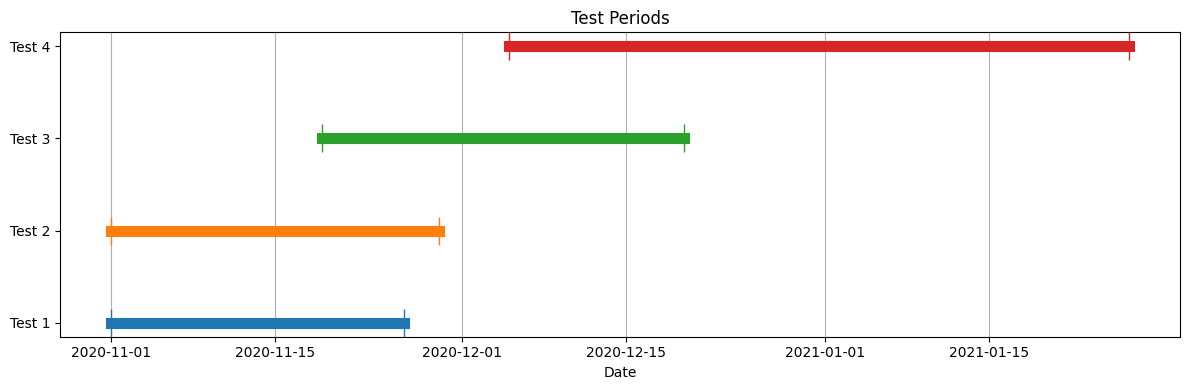

In [ ]:
plt.figure(figsize=(12, 4))
for i, row in tests_df.iterrows():
    plt.plot([row['start'], row['end']], [i, i], marker = '|', markersize=20, linewidth=8)

plt.yticks(range(len(tests_df)), tests_df['test'])
plt.xlabel('Date')
plt.title('Test Periods')
plt.grid(axis='x')
plt.tight_layout()
plt.show()

Tests 1 and 2 ran fully in parallel, with Test 2 lasting slightly longer. Tests 1–3 overlapped from Nov 19–26, and Tests 3–4 from Dec 5–20, increasing the risk of interference and unclear results.

In [ ]:
for i in range(1, 5):
    df_test = test_number[i]

    print(f"\nTest {i} - Group distribution (%)")
    print("-" * 33)

    group_dist = pd.crosstab(
        df_test['test_group'],
        columns='%',
        normalize=True
    ) * 100

    group_dist.columns.name = None
    print(group_dist.round(2))


Test 1 - Group distribution (%)
---------------------------------
                %
test_group       
1           49.85
2           50.15

Test 2 - Group distribution (%)
---------------------------------
                %
test_group       
1           50.58
2           49.42

Test 3 - Group distribution (%)
---------------------------------
                %
test_group       
1           49.69
2           50.31

Test 4 - Group distribution (%)
---------------------------------
                %
test_group       
1           50.08
2           49.92


Each test shows a well-balanced distribution between the two test groups.

In [ ]:
features = ['continent', 'device', 'channel']

for i in range(1, 5):
    df_test = test_number[i]
    print(f"\nTest {i} - Group distribution by categories (%)")
    print("=" * 45)

    for feature in features:
        print(f"\nBy {feature}")
        print("-" * 30)

        crosstab = pd.crosstab(
            df_test[feature],
            df_test['test_group'],
            normalize='index'
        ) * 100

        crosstab.columns.name = None
        print(crosstab.round(2))


Test 1 - Group distribution by categories (%)

By continent
------------------------------
               1      2
continent              
Africa     51.90  48.10
Americas   49.88  50.12
Asia       49.26  50.74
Europe     50.18  49.82
Oceania    50.38  49.62
Undefined  49.63  50.37

By device
------------------------------
             1      2
device               
Desktop  49.50  50.50
Mobile   50.31  49.69
Tablet   49.62  50.38

By channel
------------------------------
                    1      2
channel                     
Direct          50.54  49.46
Organic Search  50.01  49.99
Paid Search     49.86  50.14
Social Search   49.63  50.37
Undefined       47.98  52.02

Test 2 - Group distribution by categories (%)

By continent
------------------------------
               1      2
continent              
Africa     54.47  45.53
Americas   50.20  49.80
Asia       50.21  49.79
Europe     50.85  49.15
Oceania    51.99  48.01
Undefined  43.19  56.81

By device
-----------------------

- Test 1

 - Group distribution is mostly balanced across continents, devices, and channels with minor deviations like Africa (52%) favoring group 1 and Undefined (52%) channel favoring group 2. Devices and channels show near-equal splits.

- Test 2

  - Group 1 is stronger in Africa (54.5%) and Oceania (52%), while Undefined continent (56.8%) favors group 2. Device and channel splits remain mostly even.

- Test 3

 - Groups are balanced overall, with Americas (51%) and Oceania (52.6%) slightly favoring group 2, and Undefined continent (53.6%) favoring group 1. Devices and channels show almost equal distribution.

- Test 4

 - Africa (51.4%) leans slightly towards group 1, while Undefined continent favors group 2. Device and channel distributions are nearly even.

Overall, group distributions across tests are generally balanced with only small variations by continent, while device and channel splits remain consistently even.

### Test events

---



In [ ]:
def ab_test_significance(
    metrics,
    test_number,
    group_col = 'test_group',
    events_col = 'event_name',
    session_event = 'session'
):
    """
    Calculate statistical significance of A/B test metrics between two groups.

    Parameters:
    -----------
    metrics : list of str
        List of event names (metrics) to evaluate conversion rates for (e.g., ['add_payment_info', 'add_shipping_info']).
    test_number : dict
        Dictionary where keys are test identifiers and values are corresponding DataFrames containing test data.
        Each DataFrame must include columns for groups, events, and metric values.
    group_col : str, optional (default='test_group')
        Name of the column representing the test groups (e.g., control and treatment).
    events_col : str, optional (default='event_name')
        Name of the column containing event names.
    session_event : str, optional (default='session')
        Event name used to count total sessions for conversion rate denominators.

    Returns:
    --------
    pandas.DataFrame
        A DataFrame summarizing the comparison for each test and metric, with columns:
          - test: Test identifier
          - metric: Name of the metric/event analyzed
          - numerator_1: Number of metric events in group 1
          - denominator_1: Number of sessions in group 1
          - conversion_rate_group_1: Conversion rate (%) in group 1
          - numerator_2: Number of metric events in group 2
          - denominator_2: Number of sessions in group 2
          - conversion_rate_group_2: Conversion rate (%) in group 2
          - metric_change_percentage: Percentage change in conversion rate from group 1 to group 2
          - z_stat: Z-test statistic for proportions test
          - p_value: P-value of the test
          - significant: Boolean indicating if p_value < 0.05 (statistically significant difference)

    Notes:
    ------
    - The function assumes exactly two groups per test for comparison.
    - Uses a two-sided z-test for proportions (from `statsmodels.stats.proportion.proportions_ztest`).
    - Conversion rates are expressed as percentages with two decimals.
    - If either group has zero sessions, conversion rate is set to zero and test is skipped for that metric.
    """
    result = []

    for test, df in test_number.items():
        group_values = sorted(df[group_col].unique())

        if len(group_values) != 2:
            continue

        df_group1 = df[df[group_col] == group_values[0]]
        df_group2 = df[df[group_col] == group_values[1]]

        sessions_group1 = df_group1[df_group1[events_col] == session_event]['value'].sum()
        sessions_group2 = df_group2[df_group2[events_col] == session_event]['value'].sum()

        for metric in metrics:
            metric_group1 = df_group1[df_group1[events_col] == metric]['value'].sum()
            metric_group2 = df_group2[df_group2[events_col] == metric]['value'].sum()

            conversion_rate_group_1 = round(metric_group1 / sessions_group1 * 100, 2) if sessions_group1 > 0 else 0
            conversion_rate_group_2 = round(metric_group2 / sessions_group2 * 100, 2) if sessions_group2 > 0 else 0

            metric_change_percentage = round((conversion_rate_group_2 / conversion_rate_group_1 - 1) * 100, 4) if conversion_rate_group_1 != 0 else 0

            if sessions_group1 > 0 and sessions_group2 > 0:
                z_stat, p_value = proportions_ztest(
                [metric_group1, metric_group2],
                [sessions_group1, sessions_group2],
                alternative='two-sided'
                )

            significant = p_value < 0.05

            result.append(
                {
                      'test': test,
                      'metric': metric,
                      'numerator_1': metric_group1,
                      'denominator_1': sessions_group1,
                      'conversion_rate_group_1': conversion_rate_group_1,
                      'numerator_2': metric_group2,
                      'denominator_2': sessions_group2,
                      'conversion_rate_group_2': conversion_rate_group_2,
                      'metric_change_percentage': metric_change_percentage,
                      'z_stat': z_stat,
                      'p_value': p_value,
                      'significant': significant
                  }
              )

    return pd.DataFrame(result)

In [ ]:
list(df['event_name'].unique())

['new_account',
 'session_with_orders',
 'session',
 'view_item',
 'page_view',
 'user_engagement',
 'session_start',
 'scroll',
 'first_visit',
 'view_promotion',
 'begin_checkout',
 'add_to_cart',
 'add_shipping_info',
 'view_search_results',
 'select_item',
 'select_promotion',
 'add_payment_info',
 'click',
 'view_item_list']

In [ ]:
df_test = ab_test_significance(['add_payment_info', 'add_shipping_info', 'begin_checkout', 'new_account', 'session_with_orders', 'add_to_cart'], test_number)

In [ ]:
df_test.to_csv('df_result.csv', index=False)

### Visualization

---



https://public.tableau.com/shared/PGFJ35KHZ?:display_count=n&:origin=viz_share_link

### Summary

---



In [ ]:
df_test[df_test['test'] == 1]

,test,metric,numerator_1,denominator_1,conversion_rate_group_1,numerator_2,denominator_2,conversion_rate_group_2,metric_change_percentage,z_stat,p_value,significant
0,1,add_payment_info,1988,45362,4.38,2229,45193,4.93,12.5571,-3.924884,0.000087,True
1,1,add_shipping_info,3034,45362,6.69,3221,45193,7.13,6.5770,-2.603571,0.009226,True
2,1,begin_checkout,3784,45362,8.34,4021,45193,8.90,6.7146,-2.978783,0.002894,True
3,1,new_account,3823,45362,8.43,3681,45193,8.15,-3.3215,1.542883,0.122859,False
4,1,session_with_orders,4514,45362,9.95,4526,45193,10.01,0.6030,-0.320049,0.748931,False
5,1,add_to_cart,1395,45362,3.08,1366,45193,3.02,-1.9481,0.460924,0.644853,False


Test 1 showed a significant uplift in early checkout steps, indicating positive user response. However, no effect was seen on account creation or orders, and cross-test interference with Tests 2 and 3 is possible.

In [ ]:
df_test[df_test['test'] == 2]

,test,metric,numerator_1,denominator_1,conversion_rate_group_1,numerator_2,denominator_2,conversion_rate_group_2,metric_change_percentage,z_stat,p_value,significant
6,2,add_payment_info,2344,50637,4.63,2409,50244,4.79,3.4557,-1.240994,0.214608,False
7,2,add_shipping_info,3480,50637,6.87,3510,50244,6.99,1.7467,-0.709557,0.477979,False
8,2,begin_checkout,4262,50637,8.42,4313,50244,8.58,1.9002,-0.952898,0.340642,False
9,2,new_account,4165,50637,8.23,4184,50244,8.33,1.2151,-0.588793,0.556000,False
10,2,session_with_orders,5102,50637,10.08,5003,50244,9.96,-1.1905,0.625388,0.531717,False
11,2,add_to_cart,2811,50637,5.55,3061,50244,6.09,9.7297,-3.669417,0.000243,True


Test 2 showed a small, significant increase in add_to_cart events but no impact on other funnel steps. Group balance was mostly even.

In [ ]:
df_test[df_test['test'] == 3]

,test,metric,numerator_1,denominator_1,conversion_rate_group_1,numerator_2,denominator_2,conversion_rate_group_2,metric_change_percentage,z_stat,p_value,significant
12,3,add_payment_info,3623,70047,5.17,3697,70439,5.25,1.5474,-0.643172,0.520112,False
13,3,add_shipping_info,5298,70047,7.56,5188,70439,7.37,-2.5132,1.413727,0.157442,False
14,3,begin_checkout,9532,70047,13.61,9264,70439,13.15,-3.3799,2.511389,0.012026,True
15,3,new_account,5856,70047,8.36,5822,70439,8.27,-1.0766,0.643489,0.519907,False
16,3,session_with_orders,6951,70047,9.92,7151,70439,10.15,2.3185,-1.426314,0.153778,False
17,3,add_to_cart,17674,70047,25.23,17229,70439,24.46,-3.0519,3.348897,0.000811,True


Test 3 showed a significant drop in begin_checkout and add_to_cart, suggesting a negative impact on early funnel engagement. Other metrics remained unchanged. Overall, the changes may harm user interaction.

In [ ]:
df_test[df_test['test'] == 4]

,test,metric,numerator_1,denominator_1,conversion_rate_group_1,numerator_2,denominator_2,conversion_rate_group_2,metric_change_percentage,z_stat,p_value,significant
18,4,add_payment_info,3731,105079,3.55,3601,105141,3.42,-3.6620,1.571106,0.116158,False
19,4,add_shipping_info,5128,105079,4.88,4956,105141,4.71,-3.4836,1.785795,0.074132,False
20,4,begin_checkout,12555,105079,11.95,12267,105141,11.67,-2.3431,1.995998,0.045934,True
21,4,new_account,8984,105079,8.55,8687,105141,8.26,-3.3918,2.375457,0.017527,True
22,4,session_with_orders,10596,105079,10.08,10481,105141,9.97,-1.0913,0.880234,0.378732,False
23,4,add_to_cart,21536,105079,20.50,21554,105141,20.50,0.0000,-0.028589,0.977192,False


Test 4 showed a significant drop in begin_checkout and new_account, suggesting reduced user engagement. Other metrics were unchanged. Due to overlap with Test 3, interference may affect the results.

#### Final conclusion

---

Early funnel gains don’t always lead to conversions. Test 1 showed strong uplift in early steps (payment, shipping, checkout), but no impact on orders. Test 2 showed slight engagement gains. Tests 3–4 revealed mid-funnel drops, risking revenue.

Action points:

- Avoid test overlap

- Focus on key KPIs (orders, revenue)

- Fix checkout, signup, and cart friction

Priority:
- Test 4 – checkout/signup decreased by 3.39%
- Test 3 – cart/checkout decreased by 3.38%

Test 1 shows strong early-funnel improvements but no lift in final conversions — promising, but not enough for rollout.

Recommendation: Do not implement yet, further testing needed.

